In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time
df_begin = pd.read_csv("total_district.txt",
                      names=['taxi_id','date_time','long','lat','district'])
df_begin['datetime'] = pd.to_datetime(df_begin['date_time'],format = '%Y-%m-%d %X')
df_begin = df_begin.set_index('datetime')
df_begin.drop(['long','lat','date_time'], axis = 1, inplace = True)
print(df_begin.head())

                     taxi_id  district
datetime                              
2008-02-02 15:36:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:56:08        1  Chaoyang
2008-02-02 16:06:08        1  Chaoyang
CPU times: user 1min 36s, sys: 3.3 s, total: 1min 40s
Wall time: 1min 40s


In [3]:
%%time
#Prevision for every 10 minutes
df = df_begin.groupby([pd.Grouper(level='datetime', freq='10Min'),
                      "district"])[['taxi_id']].count().reset_index()

CPU times: user 38.1 s, sys: 960 ms, total: 39.1 s
Wall time: 39.1 s


In [4]:
df.datetime = pd.to_datetime(df.datetime,format = '%Y-%m-%d %X')
df.columns=['datetime','district','taxi_count']

In [5]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

In [6]:
res = requests.get("https://www.sunrise-and-sunset.com/en/sun/china/beijing/2008/february/2")
soup = BeautifulSoup(res.content,'lxml')
all_tables=soup.find_all("table")

In [7]:
df_sunrise = pd.read_html(str(all_tables[1]))[0][1:8].reset_index()
df_sunrise.drop('index',axis=1,inplace=True)
df_sunrise.columns=["Day","Sunrise","Sunset","Day Lenght"]

/home/pranav/.local/lib/python3.5/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [8]:
df_sunrise = pd.concat([df_sunrise,pd.DataFrame([day.split(',') for day in df_sunrise.Day])],
                        axis=1,ignore_index=True)
df_sunrise.columns=["Day","Sunrise","Sunset","Day Length","Date","WeekDay"]
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)

In [9]:
def weekday(x):
    app = str(x)
    #ipdb.set_trace()
    if(app == "2008-02-02"):
        return "Saturday"
    if(app == "2008-02-03"):
        return "Sunday"
    if(app == "2008-02-04"):
        return "Monday"
    if(app == "2008-02-05"):
        return "Tuesday"
    if(app == "2008-02-06"):
        return "Wednesday"
    if(app == "2008-02-07"):
        return "Thursday"
    if(app == "2008-02-08"):
        return "Friday"
    
def working_or_not(x):
    # 0 --> day off, 1 --> day on
    app = str(x)
    #ipdb.set_trace()
    if(app == "2008-02-02"):
        return 0
    if(app == "2008-02-03"):
        return 0
    if(app == "2008-02-04"):
        return 1
    if(app == "2008-02-05"):
        return 1
    if(app == "2008-02-06"):
        return 0
    if(app == "2008-02-07"):
        return 0
    if(app == "2008-02-08"):
        return 0

def is_sun_up(data,sunrise_table):
    detail  = sunrise_table[data.date()==sunrise_table.Date.dt.date].reset_index()
    sunrise = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunrise'])
    sunset  = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunset'])
    if ((sunrise < data) & (data < sunset))[0]:
        return 1
    else:
        return 0

def is_time_to_eat(time):
    hour = time.hour
    if(6<=hour<=9 or 12<=hour<=14 or 18<=hour<=21):
        return 1 #yes
    else:
        return 0 #no

In [10]:
%%time
from math import pi
df['Weekday'] = df.datetime.dt.date.apply(weekday)
df['working_or_not'] = df.datetime.dt.date.apply(working_or_not)
df["is_sun_up"]  = df.datetime.apply(lambda x: is_sun_up(x,df_sunrise)) 
df["time_to_eat"] = df.datetime.apply(is_time_to_eat)
df['sin_frequency'] = np.sin(pi*np.array(df.datetime.dt.hour)/24)

CPU times: user 1min 58s, sys: 116 ms, total: 1min 58s
Wall time: 1min 58s


In [11]:
%matplotlib inline

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

In [12]:
df2 = df.copy()

In [13]:
prova = df2.groupby("datetime")[["taxi_count"]].sum()

In [14]:
for i in range(1,25):
    sf = "sin_frequency_{0}".format(i)
    prova[sf] = np.sin(pi*np.array(prova.index.hour)/i)

In [15]:
#prova['sin_frequency'] = np.sin(pi*np.array(prova.index.hour)/12)
#prova['sin_frequency24']= np.sin(pi*np.array(prova.index.hour)/24)

In [16]:
for i in range(1,7):
    sh = "shift_{0}".format(i)
    prova[sh] = prova.taxi_count.shift(i)

In [17]:
prova["shift_12"] = prova.taxi_count.shift(12)
prova["shift_24"] = prova.taxi_count.shift(24)

In [18]:
prova

,taxi_count,sin_frequency_1,sin_frequency_2,sin_frequency_3,sin_frequency_4,sin_frequency_5,sin_frequency_6,sin_frequency_7,sin_frequency_8,sin_frequency_9,...,sin_frequency_23,sin_frequency_24,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_12,shift_24
datetime,,,,,,,,,,,,,,,,,,,,,
2008-02-02 13:30:00,19721,-1.960673e-15,1.000000e+00,8.660254e-01,-7.071068e-01,9.510565e-01,5.000000e-01,-4.338837e-01,-9.238795e-01,-9.848078e-01,...,0.979084,0.991445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-02 13:40:00,28444,-1.960673e-15,1.000000e+00,8.660254e-01,-7.071068e-01,9.510565e-01,5.000000e-01,-4.338837e-01,-9.238795e-01,-9.848078e-01,...,0.979084,0.991445,19721.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-02 13:50:00,28627,-1.960673e-15,1.000000e+00,8.660254e-01,-7.071068e-01,9.510565e-01,5.000000e-01,-4.338837e-01,-9.238795e-01,-9.848078e-01,...,0.979084,0.991445,28444.0,19721.0,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-02 14:00:00,25055,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,28627.0,28444.0,19721.0,NaN,NaN,NaN,NaN,NaN
2008-02-02 14:10:00,24114,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,25055.0,28627.0,28444.0,19721.0,NaN,NaN,NaN,NaN
2008-02-02 14:20:00,25414,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,24114.0,25055.0,28627.0,28444.0,19721.0,NaN,NaN,NaN
2008-02-02 14:30:00,25450,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,25414.0,24114.0,25055.0,28627.0,28444.0,19721.0,NaN,NaN
2008-02-02 14:40:00,24255,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,25450.0,25414.0,24114.0,25055.0,28627.0,28444.0,NaN,NaN
2008-02-02 14:50:00,24671,-1.714506e-15,8.572528e-16,8.660254e-01,-1.000000e+00,5.877853e-01,8.660254e-01,-2.449294e-16,-7.071068e-01,-9.848078e-01,...,0.942261,0.965926,24255.0,25450.0,25414.0,24114.0,25055.0,28627.0,NaN,NaN


In [19]:
prova.dropna(inplace = True)

In [20]:
prova.reset_index(inplace = True)

In [21]:
prova['Weekday'] = prova.datetime.dt.date.apply(weekday)
prova['working_or_not'] = prova.datetime.dt.date.apply(working_or_not)
prova["is_sun_up"]  = prova.datetime.apply(lambda x: is_sun_up(x,df_sunrise)) 
prova["time_to_eat"] = prova.datetime.apply(is_time_to_eat)
#prova['sin_frequency'] = np.sin(pi*np.array(df.datetime.dt.hour)/12)

In [22]:
prova.drop("datetime", axis = 1,inplace = True)

In [23]:
prova = pd.get_dummies(prova,columns=['Weekday'])

In [24]:
Y = prova["taxi_count"].values
X = prova.drop(['taxi_count'], axis = 1).values
display(X)
display(Y)

array([[-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.47081412e-15,  1.00000000e+00, -8.66025404e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

array([25228, 26383, 24781, 25488, 24913, 24911, 25687, 27271, 24935,
       28155, 28155, 28500, 28800, 26987, 28439, 29643, 27547, 27173,
       25860, 27787, 25746, 23847, 25002, 23981, 26202, 24437, 23565,
       22667, 24576, 22768, 23925, 23996, 24137, 23259, 22002, 21052,
       22027, 21243, 20259, 20450, 19271, 19988, 19992, 19335, 19931,
       20927, 18892, 19445, 19581, 16369, 17552,  8243,  8683,  8125,
       16330, 16376, 17535, 16371, 15365, 14861, 11835, 11641, 12062,
       11857, 13046, 15001, 13917, 13101, 14936, 14016, 14207, 13953,
       13403, 13357, 12293, 13295, 13146, 13151, 12281, 14042, 13017,
       14233, 11270, 10657, 11810, 12382, 12058, 12913, 13647,  7093,
        7342, 14814, 14443, 14576, 17099, 15788, 19902, 21229, 20012,
       20716, 21556, 23205, 22163, 21866, 23338, 20829, 22877, 24652,
       23991, 24121, 24506, 22983, 21288, 19503, 25038, 26582, 26663,
       28230, 26348, 29137, 28083, 25654, 26979, 25923, 26564, 26380,
       28326, 26906,

In [25]:
import plotly.plotly as py
import cufflinks as cf

py.iplot([{
    'x': prova.index,
    'y': prova.taxi_count
}])

/home/pranav/.local/lib/python3.5/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [35]:
time_series_simple = prova.iloc[:,0:1].values #needed or the first LSTM
prova_copy = prova #need for the second LSTM

# Random Forest

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X.shape

(862, 42)

In [32]:
2000/60

33.333333333333336

Prevediamo 33 ore ovvero un giorno e mezzo. 

In [33]:
x_train, x_test, y_train, y_test = X[1:662], X[662:861], Y[1:662], Y[662:861]

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
rfr= RandomForestRegressor(bootstrap = False, random_state=0)
rfr.fit(x_train,y_train)

/home/pranav/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [36]:
y_pred = rfr.predict(x_test)

In [37]:
y_pred_train = rfr.predict(x_train)

In [38]:
# Check overfitting

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("MSE: "+str(mean_squared_error(y_test, y_pred)))
print("R-squared: "+str(r2_score(y_test, y_pred)))
print("MSE: "+str(mean_squared_error(y_train, y_pred_train)))
print("R-squared: "+str(r2_score(y_train, y_pred_train)))

MSE: 3328503.9348241217
R-squared: 0.838331498395718
MSE: 0.0
R-squared: 1.0


In [40]:
np.sqrt(mean_squared_error(y_test, y_pred))/np.mean(Y)

0.0921245781298366

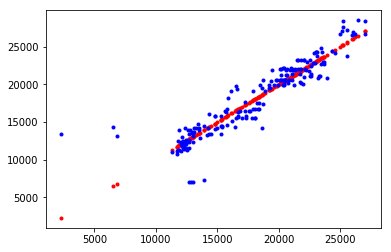

In [41]:
plt.plot(y_test,y_test,'r.')
plt.plot(y_test, y_pred,'b.')

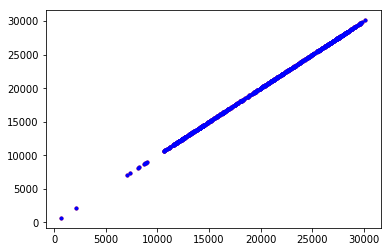

In [42]:
plt.plot(y_train,y_train,'r.')
plt.plot(y_train, y_pred_train,'b.')

# ElasticNet

In [43]:
from sklearn.linear_model import ElasticNet

In [44]:
def overfit_eval(model, X, Y):
    
    """
    model: il nostro modello predittivo già addestrato
    X: una tupla contenente le prorietà del train set e test set (X_train, X_test)
    Y: una tupla contenente target del train set e test set (Y_train, Y_test)
    """
    
    Y_pred_train = model.predict(X[0])
    Y_pred_test = model.predict(X[1])
    
    mse_train = mean_squared_error(Y[0], Y_pred_train)
    mse_test = mean_squared_error(Y[1], Y_pred_test)

    r2_train = r2_score(Y[0], Y_pred_train)
    r2_test = r2_score(Y[1], Y_pred_test)    
    
    print("Train set:  MSE="+str(mse_train)+" R2="+str(r2_train))
    print("Test set:  MSE="+str(mse_test)+" R2="+str(r2_test))

l1 ratio è il rapporto tra l1 e l2. Se l1/l2 = 0 -> la penalità è un l2. Viceversa se l1/l2 è 1 allora la penalità è un l1. 

In [45]:
alphas = [0.0001, 0.001, 0.01, 0.1 ,1 ,1] #alpha corrispone a lambda
l1_re = [0, 0.5,0.5,0.8,0.9,1]
for alpha in alphas:
        #print("Alpha="+str(alpha))
        #print("L1 ratio="+str(l1_res))
    elastic = ElasticNet(alpha=alpha, l1_ratio=1)
    elastic.fit(x_train, y_train)

    overfit_eval(elastic, (x_train, x_test),(y_train, y_test))

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 799909187.1863197, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 799846901.8696167, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 799199879.6549302, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 782340

Train set:  MSE=2420321.469999885 R2=0.9320458123685199
Test set:  MSE=1681572.7572590897 R2=0.9183244624828653
Train set:  MSE=2420321.6355837598 R2=0.9320458077195021
Test set:  MSE=1682311.7318598418 R2=0.9182885698059249
Train set:  MSE=2420325.0310414657 R2=0.9320457123868892
Test set:  MSE=1695413.9677434117 R2=0.9176521821421457
Train set:  MSE=2420477.4473368474 R2=0.9320414330687643
Test set:  MSE=1781405.3815591228 R2=0.9134754999766327
Train set:  MSE=2421217.051014397 R2=0.9320206675763699
Test set:  MSE=1762697.948898504 R2=0.9143841372101545
Train set:  MSE=2421217.051014397 R2=0.9320206675763699
Test set:  MSE=1762697.948898504 R2=0.9143841372101545


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 36336670.46169782, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 36336670.46169782, tolerance: 2354280.9463721635



In [46]:
alphas = [0.0001, 0.001, 0.01, 0.1 ,1 ,1] #alpha corrispone a lambda
l1_re = [0, 0.5,0.5,0.8,0.9,1]
for alpha in alphas:
    for l1_res in l1_re:
        print("Lambda="+str(alpha))
        print("L1 ratio="+str(l1_res))
        elastic = ElasticNet(alpha=alpha, l1_ratio=l1_res)
        elastic.fit(x_train, y_train)
        overfit_eval(elastic, (x_train, x_test),(y_train, y_test))

Lambda=0.0001
L1 ratio=0
Train set:  MSE=2420453.214341099 R2=0.9320421134467887
Test set:  MSE=1726302.3917311495 R2=0.9161519029414005
Lambda=0.0001
L1 ratio=0.5
Train set:  MSE=2420389.671021291 R2=0.9320438975216442
Test set:  MSE=1705865.8615423867 R2=0.9171445240343308
Lambda=0.0001
L1 ratio=0.5
Train set:  MSE=2420389.671021291 R2=0.9320438975216442
Test set:  MSE=1705865.8615423867 R2=0.9171445240343308
Lambda=0.0001
L1 ratio=0.8


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 800090475.7065966, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 800006460.9023432, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 800006460.9023432, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 799950

Train set:  MSE=2420349.2965450706 R2=0.9320450310961576
Test set:  MSE=1690152.0261359233 R2=0.9179077594921713
Lambda=0.0001
L1 ratio=0.9
Train set:  MSE=2420335.47216051 R2=0.9320454192366727
Test set:  MSE=1685367.7765445127 R2=0.9181401349010304
Lambda=0.0001
L1 ratio=1
Train set:  MSE=2420321.469999885 R2=0.9320458123685199
Test set:  MSE=1681572.7572590897 R2=0.9183244624828653
Lambda=0.001
L1 ratio=0
Train set:  MSE=2421044.4295950346 R2=0.9320255141839243
Test set:  MSE=1737871.854379172 R2=0.9155899634853273
Lambda=0.001
L1 ratio=0.5


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 799930422.0452104, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 799909187.1863197, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 800971960.5101364, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 800431

Train set:  MSE=2420813.789479514 R2=0.9320319897541656
Test set:  MSE=1744006.5308941465 R2=0.9152919965970726
Lambda=0.001
L1 ratio=0.5
Train set:  MSE=2420813.789479514 R2=0.9320319897541656
Test set:  MSE=1744006.5308941465 R2=0.9152919965970726
Lambda=0.001
L1 ratio=0.8
Train set:  MSE=2420566.5451387325 R2=0.9320389315131561
Test set:  MSE=1743127.5232794902 R2=0.9153346908064661
Lambda=0.001
L1 ratio=0.9
Train set:  MSE=2420453.3555408986 R2=0.9320421094823905
Test set:  MSE=1727888.235437597 R2=0.9160748770520459
Lambda=0.001
L1 ratio=1
Train set:  MSE=2420321.6355837598 R2=0.9320458077195021
Test set:  MSE=1682311.7318598418 R2=0.9182885698059249
Lambda=0.01
L1 ratio=0
Train set:  MSE=2423720.0001080893 R2=0.9319503934931735
Test set:  MSE=1653339.8523117155 R2=0.9196957606781366
Lambda=0.01
L1 ratio=0.5
Train set:  MSE=2422011.4076512745 R2=0.9319983648117919
Test set:  MSE=1696402.6182033063 R2=0.9176041624787801
Lambda=0.01
L1 ratio=0.5


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 799846901.8696167, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 807089192.515182, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 800174121.3767235, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8001741

Train set:  MSE=2422011.4076512745 R2=0.9319983648117919
Test set:  MSE=1696402.6182033063 R2=0.9176041624787801
Lambda=0.01
L1 ratio=0.8
Train set:  MSE=2421294.21381152 R2=0.9320185011140801
Test set:  MSE=1726578.963951535 R2=0.9161384695739385
Lambda=0.01
L1 ratio=0.9
Train set:  MSE=2421041.5626930273 R2=0.9320255946765363
Test set:  MSE=1738138.429864847 R2=0.915577015668477
Lambda=0.01
L1 ratio=1


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 798127428.0626348, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 796688601.7332891, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 799199879.6549302, tolerance: 2354280.9463721635



Train set:  MSE=2420325.0310414657 R2=0.9320457123868892
Test set:  MSE=1695413.9677434117 R2=0.9176521821421457
Lambda=0.1
L1 ratio=0
Train set:  MSE=2471249.212621955 R2=0.9306159389320016
Test set:  MSE=1378071.6065688694 R2=0.933065792890773
Lambda=0.1
L1 ratio=0.5
Train set:  MSE=2445832.0460872413 R2=0.9313295643429932
Test set:  MSE=1466716.059534178 R2=0.9287602501703646
Lambda=0.1
L1 ratio=0.5
Train set:  MSE=2445832.0460872413 R2=0.9313295643429932
Test set:  MSE=1466716.059534178 R2=0.9287602501703646
Lambda=0.1
L1 ratio=0.8


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 837251727.7087295, tolerance: 2354280.9463721635



Train set:  MSE=2428704.117400383 R2=0.9318104568583686
Test set:  MSE=1585170.9336926616 R2=0.9230067878377632
Lambda=0.1
L1 ratio=0.9
Train set:  MSE=2423836.7501307726 R2=0.931947115559624
Test set:  MSE=1652139.1960626883 R2=0.9197540776579338
Lambda=0.1
L1 ratio=1


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 322624504.7464706, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 782340872.793282, tolerance: 2354280.9463721635



Train set:  MSE=2420477.4473368474 R2=0.9320414330687643
Test set:  MSE=1781405.3815591228 R2=0.9134754999766327
Lambda=1
L1 ratio=0
Train set:  MSE=2632549.9103775495 R2=0.9260871777669103
Test set:  MSE=1294950.211511746 R2=0.9371030756019478
Lambda=1
L1 ratio=0.5


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 888535881.1888, tolerance: 2354280.9463721635

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 36336670.46169782, tolerance: 2354280.9463721635



Train set:  MSE=2577210.2636882896 R2=0.9276409220860821
Test set:  MSE=1284040.6164944083 R2=0.9376329646794729
Lambda=1
L1 ratio=0.5
Train set:  MSE=2577210.2636882896 R2=0.9276409220860821
Test set:  MSE=1284040.6164944083 R2=0.9376329646794729
Lambda=1
L1 ratio=0.8
Train set:  MSE=2511110.392723232 R2=0.9294967759838605
Test set:  MSE=1313220.2928779833 R2=0.9362156809235864
Lambda=1
L1 ratio=0.9
Train set:  MSE=2473716.6305129835 R2=0.9305466624410847
Test set:  MSE=1374784.9786688462 R2=0.9332254274348
Lambda=1
L1 ratio=1
Train set:  MSE=2421217.051014397 R2=0.9320206675763699
Test set:  MSE=1762697.948898504 R2=0.9143841372101545
Lambda=1
L1 ratio=0


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 888535881.1888, tolerance: 2354280.9463721635



Train set:  MSE=2632549.9103775495 R2=0.9260871777669103
Test set:  MSE=1294950.211511746 R2=0.9371030756019478
Lambda=1
L1 ratio=0.5
Train set:  MSE=2577210.2636882896 R2=0.9276409220860821
Test set:  MSE=1284040.6164944083 R2=0.9376329646794729
Lambda=1
L1 ratio=0.5
Train set:  MSE=2577210.2636882896 R2=0.9276409220860821
Test set:  MSE=1284040.6164944083 R2=0.9376329646794729
Lambda=1
L1 ratio=0.8
Train set:  MSE=2511110.392723232 R2=0.9294967759838605
Test set:  MSE=1313220.2928779833 R2=0.9362156809235864
Lambda=1
L1 ratio=0.9
Train set:  MSE=2473716.6305129835 R2=0.9305466624410847
Test set:  MSE=1374784.9786688462 R2=0.9332254274348
Lambda=1
L1 ratio=1
Train set:  MSE=2421217.051014397 R2=0.9320206675763699
Test set:  MSE=1762697.948898504 R2=0.9143841372101545


/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 36336670.46169782, tolerance: 2354280.9463721635



Dai risultati emerge che lambda = 0.01 e l1 ratio = 0.9 (penalità l1) risulta il valore ottimale

In [47]:
#GridSeach CV for Random Forest

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
#Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
#max_depth.append(None)
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
#Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#Method of selecting samples for training each tree
#bootstrap = [True, False]

#Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor(bootstrap = False)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 1)

%%time
rf_random.fit(x_train, y_train)

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = np.sqrt(mean_squared_error(y_test, predictions))
    param = model.best_params_
    estimator = model.best_estimator_
    print('Model Performance')
    print('MSE of: ', errors)
    print("Parameters: ", param)
    print("Estimator: ", estimator )
    
    return errors

random_accuracy = evaluate(rf_random, x_test, y_test)

y_pred_random = rf_random.predict(x_test)
y_pred_train_r = rf_random.predict(x_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("MSE: "+str(mean_squared_error(y_test, y_pred_random)))
print("R-squared: "+str(r2_score(y_test, y_pred_random)))
print("MSE: "+str(mean_squared_error(y_train, y_pred_train_r)))
print("R-squared: "+str(r2_score(y_train, y_pred_train_r)))

plt.plot(y_train,y_train,'r.')
plt.plot(y_train, y_pred_train_r,'b.')

plt.figure(figsize = (15,10))
plt.plot(y_test,'r')
plt.plot(y_pred_random,'b')

In [48]:
X_t = (X[0:800])
X_val = X[800:861]
Y_t = Y[0:800]
Y_val = Y[800:861]

# Random Forest R. CV for Time Series

In [49]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=None,n_splits=X_t.shape[0]-1)
y_ = []
y_pred = []
for train_index, test_index in tscv.split(X_t):
    if train_index.shape[0] > 100: #le previsioni iniziano dalla 100-esima osservazione (1000 minuti) in poi
    #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_t[train_index], X[test_index]
    #ipdb.set_trace()
        y_train, y_test = Y_t[train_index], Y_t[test_index]
        #lr = RandomForestRegressor(bootstrap = False, random_state=0,
        #                  n_estimators = 200, min_samples_split = 5,
        ##                   min_samples_leaf= 1, max_features = "sqrt",
         #                  max_depth = 15)
        lr=RandomForestRegressor(bootstrap = False, random_state=0,
                          n_estimators = 100, min_samples_split = 100,
                           min_samples_leaf= 70, max_features="sqrt")
        #200 alberi, si splitta quando ci sono almeno 5 osservazioni, ci deve essere almeno 1 elemento dentro ogni foglia
        lr.fit(X_train, y_train)

    #overfit_eval(lasso, (X_train, X_test),(y_train, y_test))
        y_pred.append(lr.predict(X_test))
        y_.append(y_test)
    #print("Predettto ", y_pred,", Osservato", y_test)

In [50]:
X_train.shape

(799, 42)

In [51]:
y_prediction = lr.predict(X_t) #predizione solo sul training set e non sul validation

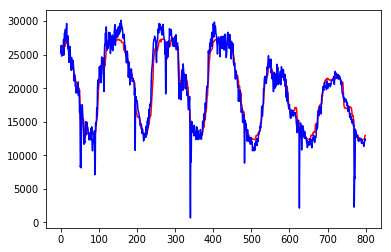

In [52]:
plt.plot(y_prediction,color="red")
plt.plot(Y_t, color= "blue")

In [53]:
r2_score(Y_t, y_prediction)

0.917458832656875

In [54]:
#validation test
y_prediction_val = lr.predict(X_val)

In [55]:
np.mean(np.abs(y_prediction_val - Y_val)/Y_val) 

0.04815711252411597

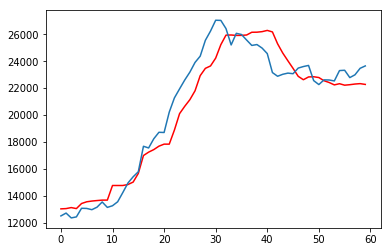

In [56]:
plt.plot(y_prediction_val[0:Y_val.shape[0]-1],color="red")
plt.plot(Y_val[0:Y_val.shape[0]-1])

In [57]:
r2_score(Y_val[0:Y_val.shape[0]-1],y_prediction_val[0:Y_val.shape[0]-1]) #R^2 sul validation set

0.9297746982267338

In [58]:
prova.head(1)

,taxi_count,sin_frequency_1,sin_frequency_2,sin_frequency_3,sin_frequency_4,sin_frequency_5,sin_frequency_6,sin_frequency_7,sin_frequency_8,sin_frequency_9,...,working_or_not,is_sun_up,time_to_eat,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,25228,-1.470814e-15,1.0,-0.866025,0.707107,-0.951057,0.5,0.974928,0.382683,-0.34202,...,0,1,0,0,0,1,0,0,0,0


In [59]:
lr.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 4.02707809e-05, 1.61754048e-04,
       4.23849011e-05, 3.05283709e-04, 1.03789274e-03, 2.09896910e-03,
       2.35496126e-02, 5.50042771e-02, 7.90180924e-02, 2.34623498e-03,
       1.23135368e-02, 1.46178200e-02, 1.11436699e-03, 3.27004407e-03,
       4.07942009e-04, 4.63852937e-03, 7.56245058e-04, 9.85442052e-04,
       3.72869958e-03, 2.82682040e-03, 3.57092931e-03, 3.72745103e-03,
       1.97508937e-01, 1.78952340e-01, 1.19113357e-01, 8.74843643e-02,
       9.00537621e-02, 4.90939496e-02, 4.68254197e-02, 9.58536188e-03,
       1.88542159e-03, 1.83643171e-03, 2.51890765e-04, 0.00000000e+00,
       2.58764527e-04, 0.00000000e+00, 0.00000000e+00, 1.48353124e-03,
       1.03869944e-04, 0.00000000e+00])

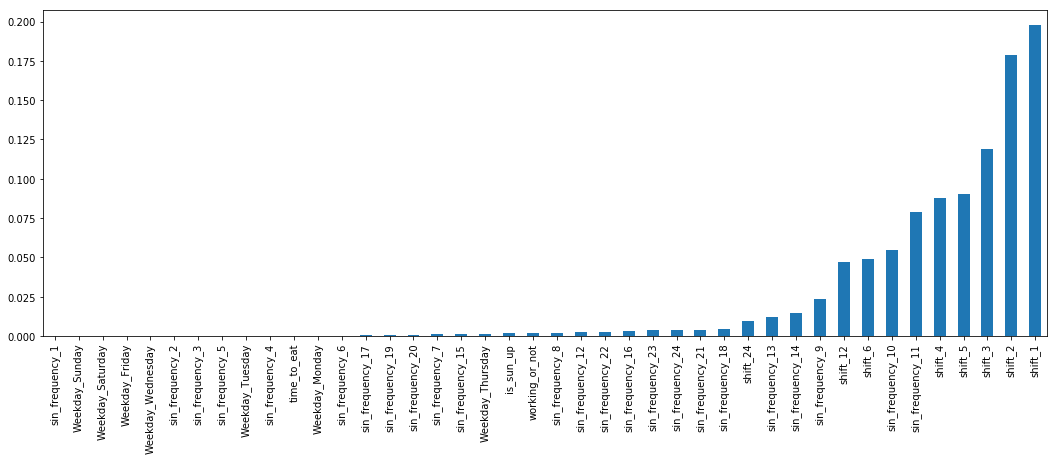

In [60]:
feature_importance = pd.Series(index = prova.columns[1:], data = lr.feature_importances_)
feature_importance.sort_values().plot(kind = 'bar', figsize = (18,6))

Proviamo con la Feature Selection e la Cross Validation

In [61]:
important_f = feature_importance.sort_values(ascending=False).head(25).index

In [62]:
df_fs = prova[important_f]

In [63]:
df_fs.columns

Index(['shift_1', 'shift_2', 'shift_3', 'shift_5', 'shift_4',
       'sin_frequency_11', 'sin_frequency_10', 'shift_6', 'shift_12',
       'sin_frequency_9', 'sin_frequency_14', 'sin_frequency_13', 'shift_24',
       'sin_frequency_18', 'sin_frequency_21', 'sin_frequency_24',
       'sin_frequency_23', 'sin_frequency_16', 'sin_frequency_22',
       'sin_frequency_12', 'sin_frequency_8', 'working_or_not', 'is_sun_up',
       'Weekday_Thursday', 'sin_frequency_15'],
      dtype='object')

In [64]:
df_fs['taxi_count'] = prova['taxi_count']

In [65]:
Y_fs = df_fs["taxi_count"].values
X_fs = df_fs.drop(['taxi_count'], axis = 1).values

In [66]:
X_t_fs = X_fs[0:800]
X_val_fs = X_fs[800:861]
Y_t_fs = Y_fs[0:800]
Y_val_fs = Y_fs[800:861]

In [67]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=None,n_splits=X_t_fs.shape[0]-1)
y_3 = []
y_pred3 = []
for train_index, test_index in tscv.split(X_t_fs):
    if train_index.shape[0] > 100:
    #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_t_fs[train_index], X_fs[test_index]
    #ipdb.set_trace()
        y_train, y_test = Y_t_fs[train_index], Y_t_fs[test_index]
        lr3 = RandomForestRegressor(bootstrap = False, random_state=0,
                          n_estimators = 100, min_samples_split = 100,
                           min_samples_leaf= 70, max_features="sqrt")
        lr3.fit(X_t_fs, Y_t_fs)

   
        y_pred3.append(lr3.predict(X_test))
        y_3.append(y_test)
    #print("Predettto ", y_pred,", Osservato", y_test)

In [68]:
y_prediction5 = lr3.predict(X_t_fs)

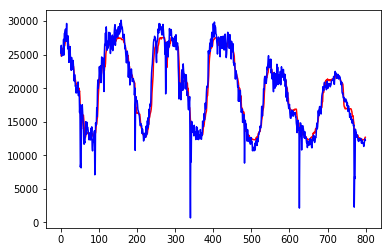

In [69]:
plt.plot(y_prediction5,color="red")
plt.plot(Y_t_fs, color= "blue")

In [70]:
r2_score(Y_t_fs, y_prediction5)

0.9170728362725099

In [71]:
y_pred5_v = lr3.predict(X_val_fs)

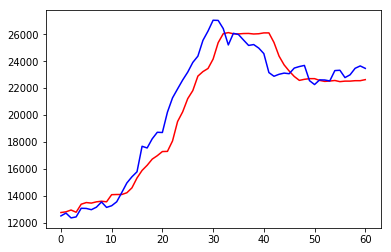

In [72]:
plt.plot(y_pred5_v,color="red")
plt.plot(Y_val_fs, color= "blue")

In [73]:
r2_score(Y_val_fs, y_pred5_v)

0.9188552261806825

# Elastic Net CV for TimeSeries

In [74]:
%%capture --no-stdout --no-display

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=None,n_splits=X_t.shape[0]-1)
y_ = []
y_pred = []
#alphas = [0.0001, 0.001, 0.01, 0.1] #alpha corrispone a lambda

for train_index, test_index in tscv.split(X_t):
    if train_index.shape[0] > 100:
        X_train, X_test = X_t[train_index], X[test_index]
        y_train, y_test = Y_t[train_index], Y_t[test_index]
        #for alpha in alphas:
        elastic = ElasticNet(alpha=0.01, l1_ratio=1)
        elastic.fit(X_train, y_train)
        #print(overfit_eval(elastic, (X_train, X_test),(y_train, y_test)))
        y_pred.append(elastic.predict(X_test))
        y_.append(y_test)
    #print("Predettto ", y_pred,", Osservato", y_test)

In [75]:
r2_score(y_,y_pred)

0.9215633500571365

In [76]:
y_pred_en_t = elastic.predict(X_t)

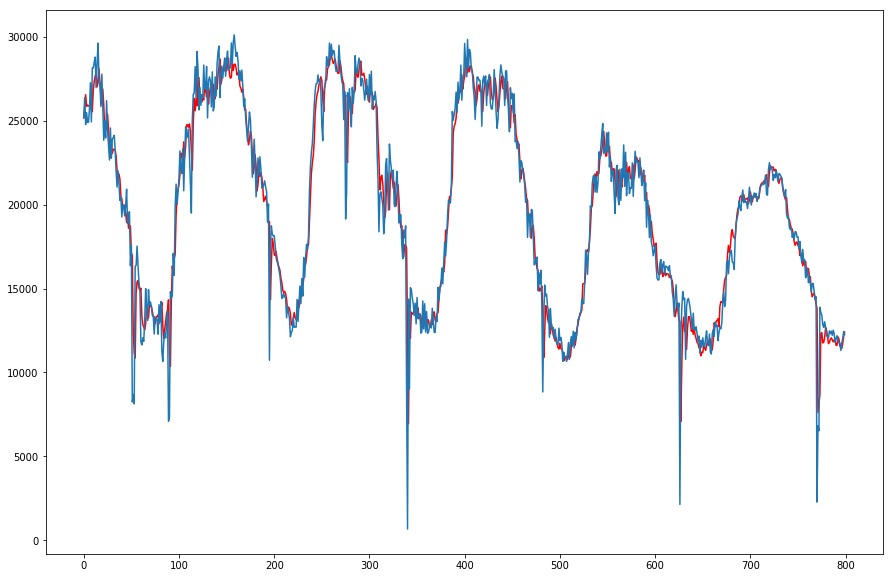

In [77]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_en_t, color = "red")
plt.plot(Y_t)

In [78]:
y_pred_en_val = elastic.predict(X_val)

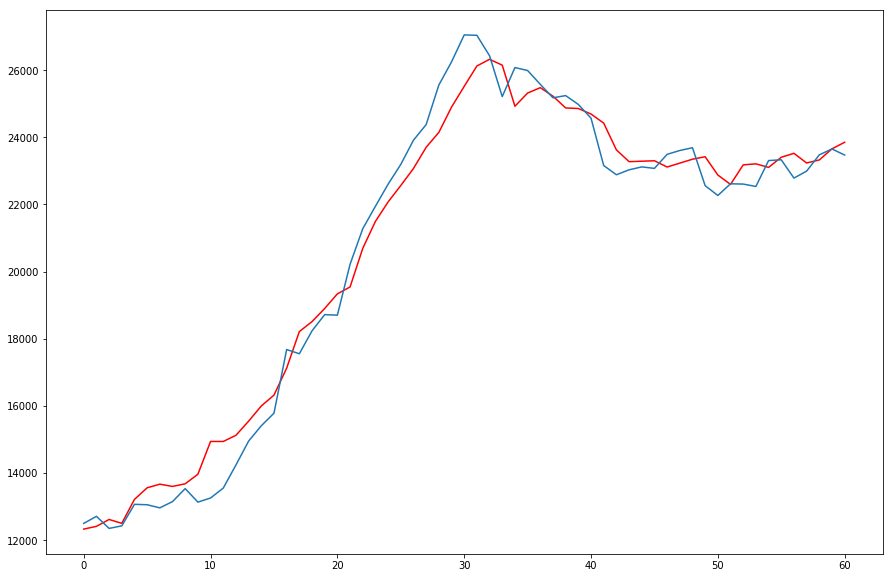

In [79]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_en_val, color = "red")
plt.plot(Y_val)

In [80]:
r2_score(Y_val, y_pred_en_val)

0.9797940246697329

# Support Vector Regressor: 

In [81]:
#prova2 = prova[["taxi_count", "sin_frequency", "shift_24"]]

In [82]:
Y2 = prova["taxi_count"].values
X2 = prova.drop("taxi_count", axis = 1).values

In [83]:
X2.shape

(862, 42)

In [84]:
X_t2 = X2[0:800]
X_val2 = X2[800:861]
Y_t = (Y2[0:800])
Y_val = (Y2[800:861])

In [85]:
x_train, x_test, y_train, y_test = X2[1:800], X2[800:861], Y2[1:800], Y2[800:861]

In [86]:
x_train.shape

(799, 42)

In [87]:
from sklearn.svm import SVR

In [88]:
svc = SVR(kernel = "linear")

In [89]:
%%time
svc.fit(x_train, y_train)

CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [90]:
svc_pred = svc.predict(x_train)

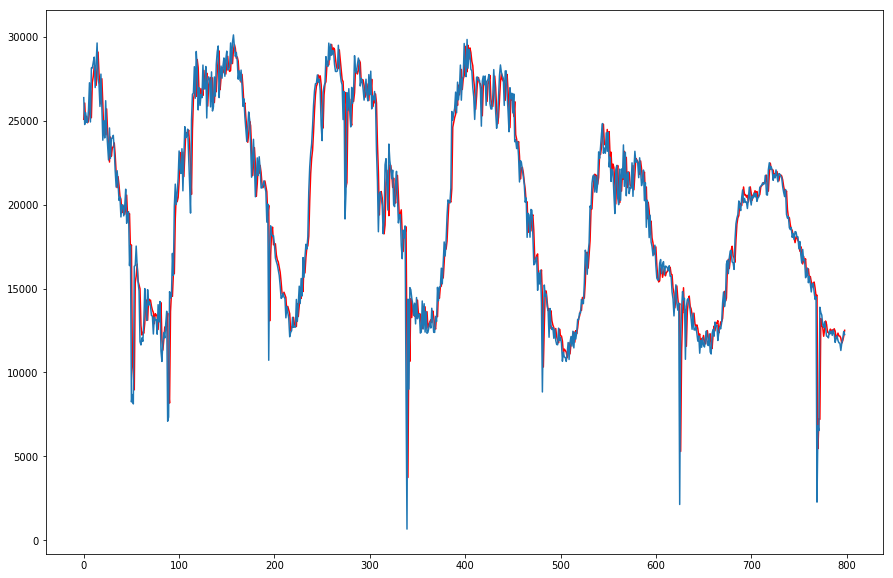

In [91]:
plt.figure(figsize = (15,10))
plt.plot(svc_pred, color = "red")
plt.plot(y_train)

In [92]:
r2_score(y_train,svc_pred)

0.9224434241374503

In [93]:
svc_pred_t = svc.predict(x_test)

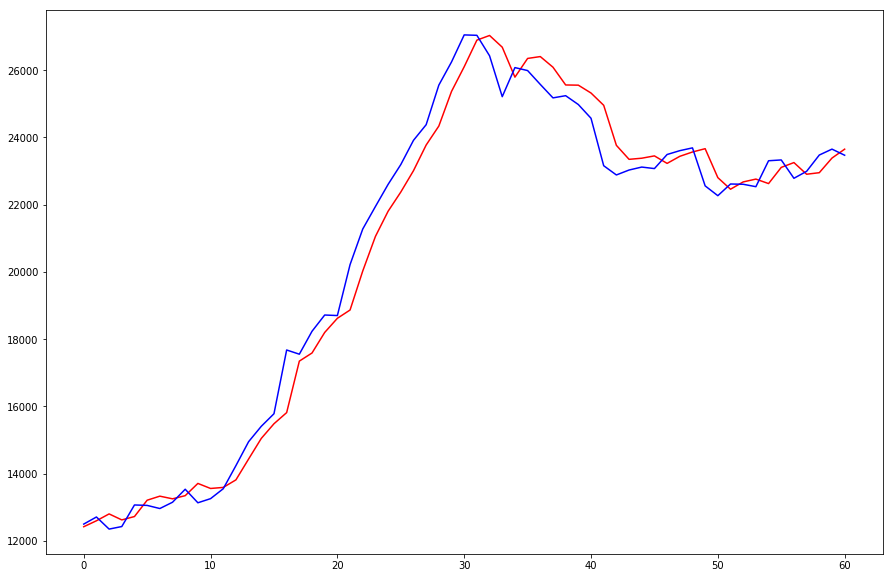

In [94]:
plt.figure(figsize = (15,10))
plt.plot(svc_pred_t, color = "red")
plt.plot(y_test, color = "blue")

In [95]:
r2_score(y_test,svc_pred_t)

0.9795360453241752

 # Ridge

In [96]:
from sklearn.linear_model import Ridge

In [97]:
alphas = [0.0001, 0.001, 0.01, 0.1 ,1 ,10] #alpha corrispone a lambda

for alpha in alphas:
    print("Alpha="+str(alpha))
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train)
    overfit_eval(ridge, (x_train, x_test),(y_train, y_test))

Alpha=0.0001
Train set:  MSE=2288236.8167329514 R2=0.9322234498944307
Test set:  MSE=435731.8772900308 R2=0.9806661185873478
Alpha=0.001
Train set:  MSE=2288591.398247293 R2=0.9322129473487162
Test set:  MSE=437854.53491761646 R2=0.9805719340371912
Alpha=0.01
Train set:  MSE=2291300.3204365303 R2=0.932132710286211
Test set:  MSE=445121.90892583854 R2=0.980249473013384
Alpha=0.1
Train set:  MSE=2297215.3522481625 R2=0.9319575096920132
Test set:  MSE=452992.2326908619 R2=0.9799002584750801
Alpha=1
Train set:  MSE=2298778.515758091 R2=0.9319112094886517
Test set:  MSE=455342.9625626307 R2=0.9797959541197123
Alpha=10
Train set:  MSE=2302301.1874075034 R2=0.9318068695314383
Test set:  MSE=458711.0549369308 R2=0.9796465083207119


I modelli migliori risultano essere quelli che hanno $\alpha$ pari a 0.001 e 0.0001

In [98]:
ridge = Ridge(alpha=0.001)
ridge.fit(x_train, y_train)
ridge_pred = ridge.predict(x_test)

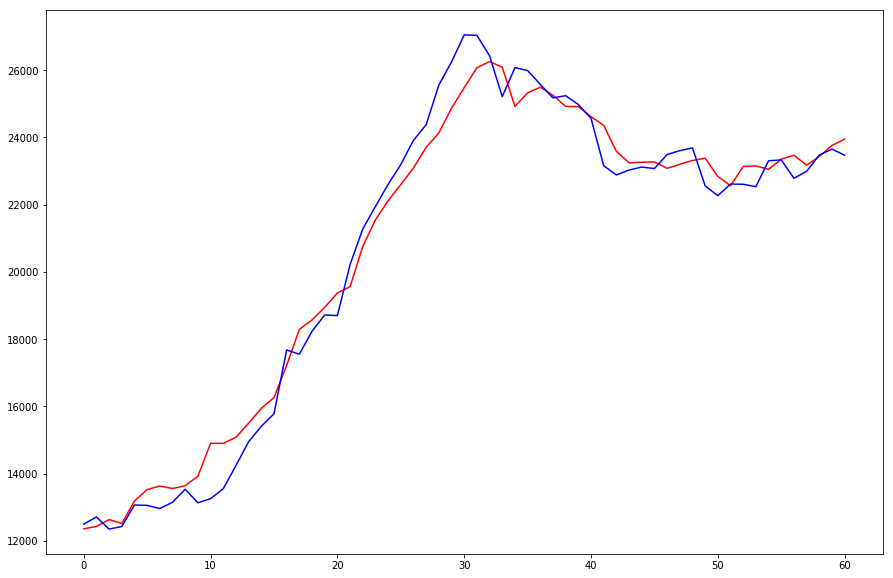

In [99]:
plt.figure(figsize = (15,10))
plt.plot(ridge_pred, color = "red")
plt.plot(y_test, color = "blue")

# Lasso

In [100]:
from sklearn.linear_model import Lasso

In [101]:
%%capture --no-stdout --no-display
alphas = [0.00001, 0.0001, 0.001, 0.01 ,0.1 ,1,10] #alpha corrispone a lambda

for alpha in alphas:
    print("Alpha="+str(alpha))
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)

    overfit_eval(lasso, (x_train, x_test),(y_train, y_test))

Alpha=1e-05
Train set:  MSE=2298277.829770959 R2=0.9319260395834417
Test set:  MSE=454543.33829280606 R2=0.9798314342890854
Alpha=0.0001
Train set:  MSE=2298277.851431881 R2=0.9319260389418548
Test set:  MSE=454543.5945126729 R2=0.9798314229203405
Alpha=0.001
Train set:  MSE=2298278.092183179 R2=0.9319260318109092
Test set:  MSE=454545.7437785205 R2=0.9798313275551557
Alpha=0.01
Train set:  MSE=2298281.935082989 R2=0.9319259179859372
Test set:  MSE=454536.8994570175 R2=0.9798317199869974
Alpha=0.1
Train set:  MSE=2298436.144274865 R2=0.9319213503787107
Test set:  MSE=455013.58381920354 R2=0.9798105690007829
Alpha=1
Train set:  MSE=2298992.708485044 R2=0.9319048651959699
Test set:  MSE=456828.1071055015 R2=0.9797300566952432
Alpha=10
Train set:  MSE=2322435.004949372 R2=0.9312105148694279
Test set:  MSE=489107.8658661776 R2=0.9782977698683317


In [102]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)
lasso_pred = lasso.predict(x_test)

/home/pranav/.local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 893241470.3406291, tolerance: 2697542.4593341686



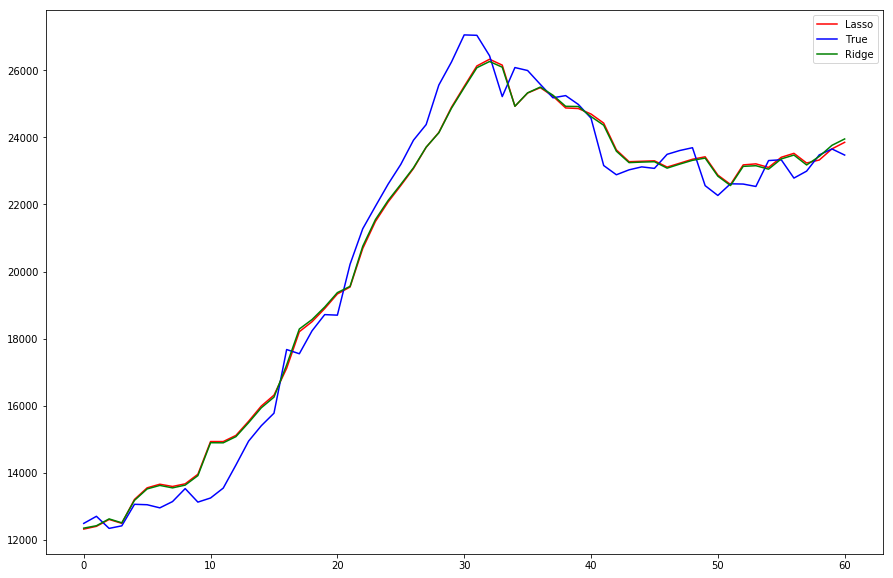

In [103]:
plt.figure(figsize = (15,10))
plt.plot(lasso_pred, color = "red")
plt.plot(y_test, color = "blue")
plt.plot(ridge_pred,color = "green")
plt.legend(["Lasso","True","Ridge"])

In [104]:
def overfit_eval_cv(model, X, Y):
    
    """
    model: il nostro modello predittivo già addestrato
    X: una tupla contenente le prorietà del train set e test set (X_train, X_test)
    Y: una tupla contenente target del train set e test set (Y_train, Y_test)
    """
    
    Y_pred_train = model.predict(X[0])
    Y_pred_test = Y[2]
    
    mse_train = mean_squared_error(Y[0], Y_pred_train)
    mse_test = mean_squared_error(Y[1], Y_pred_test)

    r2_train = r2_score(Y[0], Y_pred_train)
    r2_test = r2_score(Y[1], Y_pred_test)    
    
    print("Train set:  MSE="+str(mse_train)+" R2="+str(r2_train))
    print("Test set:  MSE="+str(mse_test)+" R2="+str(r2_test))

In [105]:
%%capture --no-stdout --no-display
import ipdb
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=None,n_splits=X_t.shape[0]-1)
y_ = []
y_pred = []

for train_index, test_index in tscv.split(X_t):
    if train_index.shape[0] > 100:
    #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_t[train_index], X[test_index]
    #ipdb.set_trace()
        y_train, y_test = Y_t[train_index], Y_t[test_index]
        lasso = Lasso(alpha=10)
        lasso.fit(X_train, y_train)
        y_pred.append(elastic.predict(X_test))
        y_.append(y_test)
        print(overfit_eval_cv(lasso, (X_train, X_test),(y_train, y_,y_pred)))
    #overfit_eval(lasso, (X_train, X_test),(y_train, y_test))
    #print("Predettto ", y_pred,", Osservato", y_test)

Train set:  MSE=2923590.049612464 R2=0.9166783561646513
Test set:  MSE=1982779.559818971 R2=nan
None
Train set:  MSE=2903625.0147624947 R2=0.9168641805584166
Test set:  MSE=1406545.9436450403 R2=-4.181774100615015
None
Train set:  MSE=2878454.481840419 R2=0.9170203111736164
Test set:  MSE=1359216.0095202748 R2=-3.1231483449299073
None
Train set:  MSE=2867034.871047166 R2=0.916743875435816
Test set:  MSE=1144969.462138921 R2=-1.8045826440422363
None
Train set:  MSE=2889716.505412613 R2=0.9157222567792108
Test set:  MSE=2619793.0917002675 R2=-2.0709278738445094
None
Train set:  MSE=2879881.467386734 R2=0.9152858368524618
Test set:  MSE=2183532.49273744 R2=-1.8716311546684534
None
Train set:  MSE=2891220.4538788036 R2=0.9144973603526654
Test set:  MSE=2064730.3607861865 R2=-0.6080205075101375
None
Train set:  MSE=2892335.4129188117 R2=0.9143957591805694
Test set:  MSE=1880731.3178151594 R2=-0.44161269087093125
None
Train set:  MSE=2866126.6480923537 R2=0.9149340008757789
Test set:  MSE=17

Train set:  MSE=2458926.3113301867 R2=0.9333305723546311
Test set:  MSE=1843147.9668215327 R2=0.6444199757647593
None
Train set:  MSE=2446991.392622067 R2=0.9333642907040665
Test set:  MSE=1822685.5774610806 R2=0.6513111739536337
None
Train set:  MSE=2453395.2474123198 R2=0.9328324406230406
Test set:  MSE=1823752.3084280142 R2=0.6661159030722277
None
Train set:  MSE=2445130.6016124994 R2=0.932683172638142
Test set:  MSE=1810322.3170442192 R2=0.6747642060784014
None
Train set:  MSE=2441354.986134774 R2=0.9324130799348087
Test set:  MSE=1821704.1883773468 R2=0.6731254268846466
None
Train set:  MSE=2446335.040360738 R2=0.9319290714795081
Test set:  MSE=1802925.013928689 R2=0.6834369166162817
None
Train set:  MSE=2435479.5882165204 R2=0.9318553370544271
Test set:  MSE=1820491.62356973 R2=0.6986038068650642
None
Train set:  MSE=2439266.7292881734 R2=0.9314022443027405
Test set:  MSE=1805657.6319496788 R2=0.7099566616170602
None
Train set:  MSE=2426547.2690901593 R2=0.931388175567723
Test se

Train set:  MSE=2338317.379179573 R2=0.9326561218533934
Test set:  MSE=1891325.493521916 R2=0.9344425941071927
None
Train set:  MSE=2331539.2274750215 R2=0.9328359683258849
Test set:  MSE=1926625.817629234 R2=0.9328404676674873
None
Train set:  MSE=2341302.570141294 R2=0.9323868553889221
Test set:  MSE=1954865.267719947 R2=0.9314248648587204
None
Train set:  MSE=2342309.904558666 R2=0.9321454935245725
Test set:  MSE=1950619.6217194481 R2=0.9313835291660484
None
Train set:  MSE=2347551.4529745984 R2=0.93196606828081
Test set:  MSE=1937955.8864049537 R2=0.9316861842785714
None
Train set:  MSE=2341546.495101813 R2=0.9321431109394694
Test set:  MSE=1925737.9247776784 R2=0.932000513701609
None
Train set:  MSE=2333611.852120367 R2=0.9323925635075223
Test set:  MSE=1925738.1675667886 R2=0.9321383610839481
None
Train set:  MSE=2330621.765955395 R2=0.9326593023024483
Test set:  MSE=1913875.0471843325 R2=0.9326018964419343
None
Train set:  MSE=2321797.1964770383 R2=0.9330367555014241
Test set:  

Train set:  MSE=2475556.8181683864 R2=0.9251710775144715
Test set:  MSE=2158132.7429660494 R2=0.9130989186681926
None
Train set:  MSE=2510584.4764330667 R2=0.9238912004078272
Test set:  MSE=2152358.584564851 R2=0.9129558241030623
None
Train set:  MSE=2502841.640165321 R2=0.9238919220605076
Test set:  MSE=2142770.946148269 R2=0.9129891790899565
None
Train set:  MSE=2495157.2414039522 R2=0.9238906904598856
Test set:  MSE=2133205.420398647 R2=0.913058395434518
None
Train set:  MSE=2487860.789077328 R2=0.9238816643878056
Test set:  MSE=2128931.6532276496 R2=0.912884494389806
None
Train set:  MSE=2481710.6973339105 R2=0.9238362663872404
Test set:  MSE=2127535.300073132 R2=0.9127625563111553
None
Train set:  MSE=2483973.892229509 R2=0.9235662041676964
Test set:  MSE=2119100.4401021902 R2=0.9129425523857925
None
Train set:  MSE=2477638.1392460037 R2=0.9235647358775659
Test set:  MSE=2117616.632506747 R2=0.9127061016532921
None
Train set:  MSE=2473207.2266098536 R2=0.9234743702962325
Test set:

Train set:  MSE=2968442.5731439753 R2=0.9166035596684736
Test set:  MSE=2852715.6866175295 R2=0.9144759074407349
None
Train set:  MSE=2965412.1899322416 R2=0.916702412730635
Test set:  MSE=2844280.0299289497 R2=0.9145994725699211
None
Train set:  MSE=2959200.457722016 R2=0.9168195869445693
Test set:  MSE=2834775.2707833336 R2=0.9148044243985305
None
Train set:  MSE=2952007.410310681 R2=0.9170031064401992
Test set:  MSE=2831737.428646299 R2=0.9149553758781204
None
Train set:  MSE=2948778.162571204 R2=0.9171836600417946
Test set:  MSE=2829927.8015787704 R2=0.9148769180481272
None
Train set:  MSE=2946606.6844466617 R2=0.9171840210844603
Test set:  MSE=2821588.1008294728 R2=0.9150980474892382
None
Train set:  MSE=2939956.004395266 R2=0.9173915695938701
Test set:  MSE=2812422.269705233 R2=0.9153595344985092
None
Train set:  MSE=2932774.5333387027 R2=0.9176257814304659
Test set:  MSE=2815755.3673052196 R2=0.9154610027715969
None
Train set:  MSE=2934893.823736072 R2=0.9177633333313724
Test se

Train set:  MSE=2664895.430368298 R2=0.921722251273678
Test set:  MSE=2478173.1811477654 R2=0.9185952622129196
None
Train set:  MSE=2659268.258950998 R2=0.9217521446139467
Test set:  MSE=2476602.149175564 R2=0.918584986119665
None
Train set:  MSE=2657025.2924678535 R2=0.9217241292793011
Test set:  MSE=2477838.0649960544 R2=0.9183896911203749
None
Train set:  MSE=2652398.1284138756 R2=0.9217176331640275
Test set:  MSE=2474637.908280822 R2=0.9183426297421332
None
Train set:  MSE=2646879.3211275474 R2=0.9217390218858194
Test set:  MSE=2468872.3156835744 R2=0.9184617451033525
None
Train set:  MSE=2646679.4058428216 R2=0.921646433222235
Test set:  MSE=2469225.52064501 R2=0.9185162416630658
None
Train set:  MSE=2653730.2801635265 R2=0.9214184447376984
Test set:  MSE=2462965.661784144 R2=0.9187821116177729
None
Train set:  MSE=2650503.4306175425 R2=0.9214914131810072
Test set:  MSE=2456452.8989704894 R2=0.9190297207680785
None
Train set:  MSE=2645773.7976584425 R2=0.9215939180338794
Test set:

Train set:  MSE=2466524.4602455627 R2=0.9332471772113362
Test set:  MSE=2252751.889425153 R2=0.9375644580391749
None
Train set:  MSE=2462188.13390612 R2=0.9332525531605984
Test set:  MSE=2248283.4553937363 R2=0.9375631693534512
None
Train set:  MSE=2457814.116043874 R2=0.9332690412784337
Test set:  MSE=2245439.174059248 R2=0.9375321685520663
None
Train set:  MSE=2454230.5631450256 R2=0.933279660696652
Test set:  MSE=2243014.6003618636 R2=0.937504194024061
None
Train set:  MSE=2450837.74595225 R2=0.9332994969868339
Test set:  MSE=2241791.850496153 R2=0.9374081296124155
None
Train set:  MSE=2451366.175815341 R2=0.93317750977
Test set:  MSE=2236963.2782801925 R2=0.9374173156269276
None
Train set:  MSE=2447318.409274149 R2=0.933184976914307
Test set:  MSE=2232023.7676030262 R2=0.937426008769795
None
Train set:  MSE=2442975.001695107 R2=0.9331963894889912
Test set:  MSE=2231343.18177737 R2=0.937336703363131
None
Train set:  MSE=2440870.4284983305 R2=0.9331685973855219
Test set:  MSE=2226765

Train set:  MSE=2310319.9877714464 R2=0.9309426926661561
Test set:  MSE=2080649.3096430493 R2=0.935300354583083
None
Train set:  MSE=2307097.094615331 R2=0.931005043618117
Test set:  MSE=2077566.9541665232 R2=0.9353650408001436
None
Train set:  MSE=2303398.382740848 R2=0.9310721732836247
Test set:  MSE=2073551.7628307126 R2=0.9354839894003011
None
Train set:  MSE=2300646.4516793853 R2=0.931131139528909
Test set:  MSE=2069605.012752618 R2=0.9355995833032105
None
Train set:  MSE=2297243.2338339514 R2=0.9312087909090094
Test set:  MSE=2066483.6628060727 R2=0.935733966693429
None
Train set:  MSE=2295898.984892902 R2=0.9312607755430676
Test set:  MSE=2063145.3305425346 R2=0.9358946389022655
None
Train set:  MSE=2294007.0908714454 R2=0.931345350395104
Test set:  MSE=2059760.6481293067 R2=0.9361120848460686
None
Train set:  MSE=2292091.1738247615 R2=0.9314764222992697
Test set:  MSE=2058002.643502482 R2=0.936220141103704
None
Train set:  MSE=2289130.444809006 R2=0.931590801951959
Test set:  M

Train set:  MSE=2416557.2556050094 R2=0.9320403794560614
Test set:  MSE=2210612.4618751784 R2=0.9373083842267851
None
Train set:  MSE=2413081.98266868 R2=0.9320434977542662
Test set:  MSE=2206939.303123407 R2=0.9373094991294679
None
Train set:  MSE=2409590.6697468623 R2=0.9320452658978489
Test set:  MSE=2203393.3689530874 R2=0.9373060446862074
None
Train set:  MSE=2406237.8459819616 R2=0.9320424646743241
Test set:  MSE=2199825.872037183 R2=0.9373009625028824
None
Train set:  MSE=2402922.2804780463 R2=0.9320374915073459
Test set:  MSE=2196670.390445367 R2=0.9372851617401753
None
Train set:  MSE=2399942.724413037 R2=0.9320234618262138
Test set:  MSE=2194268.8395669004 R2=0.9372488115070589
None
Train set:  MSE=2397540.7238795646 R2=0.93199370711536
Test set:  MSE=2190562.3646940347 R2=0.9372486477025977
None
Train set:  MSE=2394111.873522026 R2=0.9319929258412807
Test set:  MSE=2187590.3979819315 R2=0.9372286347413796
None
Train set:  MSE=2391295.8105413048 R2=0.9319763452083191
Test set

Train set:  MSE=2208317.888046542 R2=0.9318069017546371
Test set:  MSE=1990361.3274437725 R2=0.9371261771405291
None
Train set:  MSE=2205611.3521163673 R2=0.9318327515564275
Test set:  MSE=1988769.113938763 R2=0.9371467146552246
None
Train set:  MSE=2205402.2738730055 R2=0.9318049999053284
Test set:  MSE=1985837.439407536 R2=0.9372060265674904
None
Train set:  MSE=2203024.8155681333 R2=0.9318411686339128
Test set:  MSE=1982953.3714898773 R2=0.9372521917687694
None
Train set:  MSE=2200172.292444214 R2=0.9318818133672737
Test set:  MSE=1981036.9409611197 R2=0.9372914044580974
None
Train set:  MSE=2199053.314794407 R2=0.9318897000819673
Test set:  MSE=1978044.549370016 R2=0.9373538606713896
None
Train set:  MSE=2196314.783668168 R2=0.9319382026985907
Test set:  MSE=1975325.4970703323 R2=0.9374201003276947
None
Train set:  MSE=2194123.7266107765 R2=0.931980800488854
Test set:  MSE=1972351.7851696352 R2=0.9375095304869588
None
Train set:  MSE=2191515.688353952 R2=0.9320498414951255
Test set

In [106]:
y_pred_lass = lasso.predict(X_t)

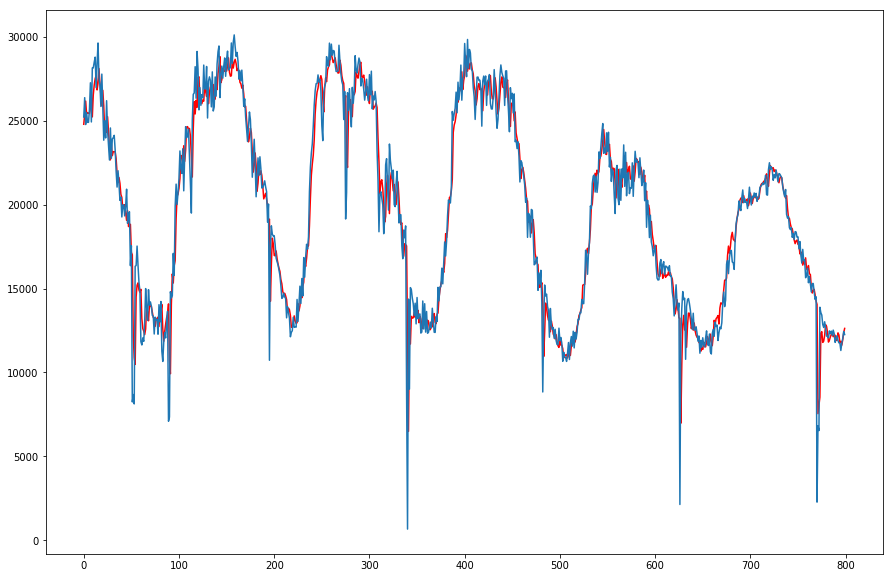

In [107]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_lass, color = "red")
plt.plot(Y_t)

In [108]:
r2_score(Y_t,y_pred_lass)

0.9312932416005563

In [109]:
y_pred_lass_v = lasso.predict(X_val)

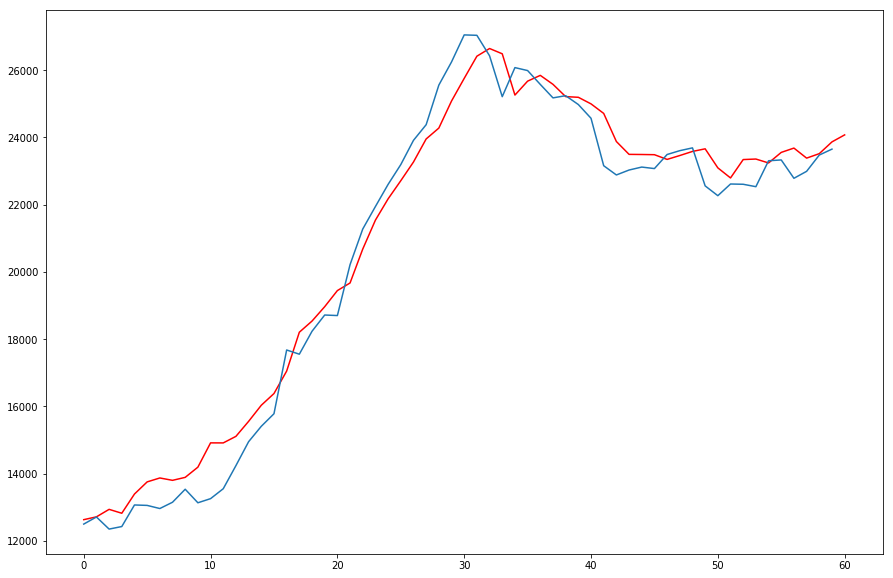

In [110]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_lass_v, color = "red")
plt.plot(Y_val[0:len(Y_val)-1])

In [111]:
y_pred_lass_v.shape

(61,)

In [112]:
Y_val.shape

(61,)

In [113]:
r2_score(Y_val,y_pred_lass_v)

0.9781774804119588

# KNN Regressor: 

In [114]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  GridSearchCV

In [115]:
x_train, x_test, y_train, y_test = X2[1:800], X2[800:861], Y2[1:800], Y2[800:861]

In [116]:
knr =  KNeighborsRegressor(n_neighbors=10, metric='euclidean', leaf_size=200)

In [117]:
#??KNeighborsRegressor

In [118]:
knr.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=200, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [119]:
y_pred_knr = knr.predict(x_train)

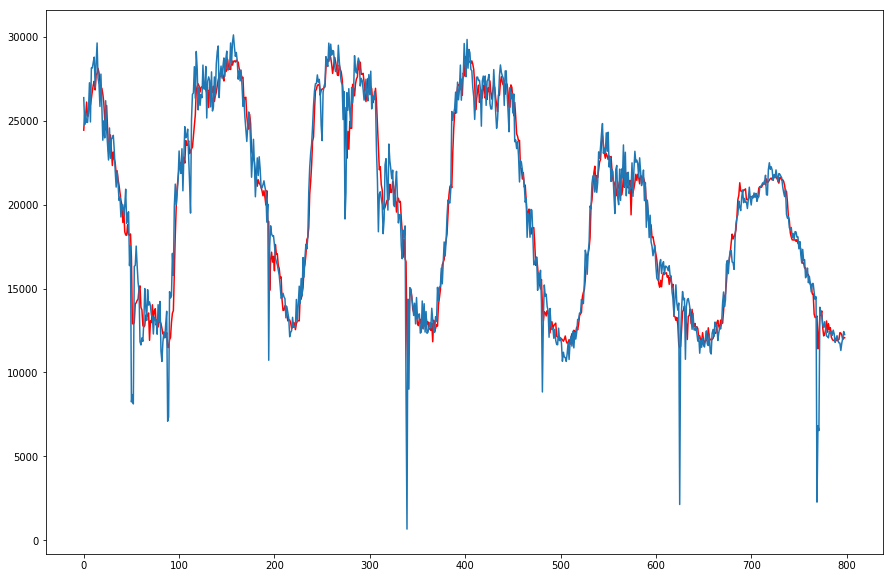

In [120]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_knr, color = "red")
plt.plot(y_train)

In [121]:
r2_score(y_train,y_pred_knr)

0.9357142002936986

In [122]:
y_pred_knr_v = knr.predict(x_test)

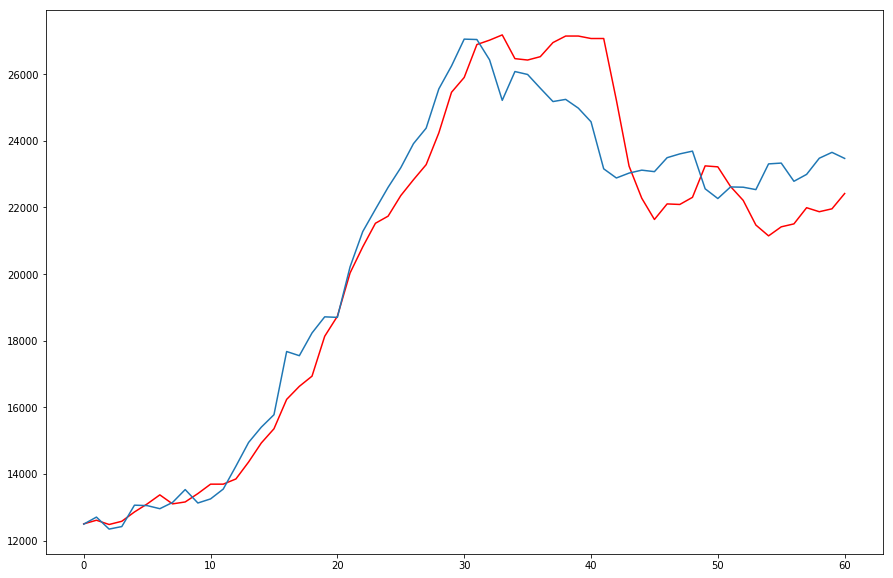

In [123]:
plt.figure(figsize = (15,10))
plt.plot(y_pred_knr_v, color = "red")
plt.plot(y_test)

In [124]:
r2_score(y_test,y_pred_knr_v)

0.9363346960100576

# LSTM

In [125]:
#Splitting the training and the test set,
#We keep the last 150 observations for testing
train, test = time_series_simple[6:-80], time_series_simple[-80:]

In [126]:
#Just checking the dimensions
train.shape

(776, 1)

In [47]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [128]:
scaler = MinMaxScaler(feature_range=(0,1))
#They work better in this range (0,1)
#We fit according to the traning set, since we
#assume not to have access to the test set
train_scaled = scaler.fit_transform(train) 

In [129]:
#number of records to use to predict the future.
old_record_number=80 #look back
features_set = []  
labels = []  
#Use N=old_record_number to predict to next one
#we create the N features for the Neurons inputs and
# the label contain the y values
#so basically a x_train and a y_train
for i in range(old_record_number, len(train_scaled)):  
    features_set.append(train_scaled[i-old_record_number:i, 0])
    labels.append(train_scaled[i, 0])
    
# We need them as np array
features_set, labels = np.array(features_set), np.array(labels)  

#Reshape them according to what LSTM wants:
# - A three dimensional array where the:
#   - first dim is the number of records
#   - second dim is the number of steps (old_record_number)
#   - third dim is the number of variabiles (for us 1, since we use only the taxi_count)
features_set = np.reshape(features_set, 
                          (features_set.shape[0], 
                           features_set.shape[1], 
                           1))  #Using only one feature

In [48]:
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import Dropout 
from livelossplot.tf_keras import PlotLossesCallback

In [49]:
class LSTM_NN:
    """This is a LSTM NN, it take in input a vector containing prende the units of 
    LSTM, the drop parameters to avoid overfitting (len(units) must be the same as len(drop)), 
    batch size and the training set divided into x_train and y_train"""
    def __init__(self,units,drop,epochs,batch_size,x_train,y_train):
        "The function compiles and fits the neural network"
        self.units = units
        self.shape_1 = x_train.shape[1]
        self.shape_2 = x_train.shape[2]
        self.drop  = drop
        self.model = Sequential()
        self.count = len(units)
        self.create_model()
        self.epochs=epochs
        self.batch_size = batch_size
        self.fit(x_train,y_train)
        
    def create_model(self):
        "Create the actual NN"
        #units is the number of neurons, return_sequences is True because 
        #we will use more layers
        if (self.count!=len(self.units)):
            print("ERROR: units and drops must have the same length")
            return
        if (self.count > 1):
            for i in range(self.count-1):
                self.model.add(LSTM(units=self.units[i],return_sequences=True,
                         input_shape = (self.shape_1,self.shape_2)))
                self.model.add(Dropout(self.drop[i])) #avoids overfitting
        
        self.model.add(LSTM(units=self.units[-1]))
        self.model.add(Dropout(self.drop[-1]))
        
        self.model.add(Dense(units=1))#output layer
        #use rmsprop as optimizer and mse as the metrics, the loss is MAE
        self.model.compile(optimizer = 'rmsprop', loss = 'mean_absolute_error',
                          metrics=['mse'])
        
    def fit(self,X_train,y_train):
        "Fitting the model with the training set"
        #remember the batch size must divide the training and the test size
        self.model.fit(X_train,y_train,
                       epochs=self.epochs,batch_size=self.batch_size)
    def predict(self,x_test):
        "return the prediction of the test set"
        return(self.model.predict(x_test))
    def get_model(self):
        return self.model

In [134]:
%%time
model = LSTM_NN(units=[80,80,80],drop=[0.1,0.1,0.2],epochs=150,
                    batch_size=40,x_train=features_set,y_train=labels).get_model()

Epoch 1/150
696/696 [==============================] - 8s 11ms/sample - loss: 0.2145 - mean_squared_error: 0.0801
Epoch 2/150
696/696 [==============================] - 6s 8ms/sample - loss: 0.1367 - mean_squared_error: 0.0298
Epoch 3/150
696/696 [==============================] - 6s 9ms/sample - loss: 0.1210 - mean_squared_error: 0.0235
Epoch 4/150
696/696 [==============================] - 6s 9ms/sample - loss: 0.1105 - mean_squared_error: 0.0200
Epoch 5/150
696/696 [==============================] - 6s 9ms/sample - loss: 0.1173 - mean_squared_error: 0.0221
Epoch 6/150
696/696 [==============================] - 6s 9ms/sample - loss: 0.1009 - mean_squared_error: 0.0169
Epoch 7/150
696/696 [==============================] - 6s 9ms/sample - loss: 0.0941 - mean_squared_error: 0.0153
Epoch 8/150
696/696 [==============================] - 6s 9ms/sample - loss: 0.0995 - mean_squared_error: 0.0159
Epoch 9/150
696/696 [==============================] - 6s 9ms/sample - loss: 0.0873 - mean_squa

696/696 [==============================] - 6s 8ms/sample - loss: 0.0449 - mean_squared_error: 0.0042
Epoch 144/150
696/696 [==============================] - 6s 8ms/sample - loss: 0.0432 - mean_squared_error: 0.0040
Epoch 145/150
696/696 [==============================] - 6s 8ms/sample - loss: 0.0438 - mean_squared_error: 0.0042
Epoch 146/150
696/696 [==============================] - 5s 8ms/sample - loss: 0.0467 - mean_squared_error: 0.0046
Epoch 147/150
696/696 [==============================] - 6s 8ms/sample - loss: 0.0442 - mean_squared_error: 0.0042
Epoch 148/150
696/696 [==============================] - 6s 8ms/sample - loss: 0.0445 - mean_squared_error: 0.0042
Epoch 149/150
696/696 [==============================] - 6s 8ms/sample - loss: 0.0439 - mean_squared_error: 0.0041
Epoch 150/150
696/696 [==============================] - 6s 8ms/sample - loss: 0.0418 - mean_squared_error: 0.0038
CPU times: user 51min 30s, sys: 4min 33s, total: 56min 3s
Wall time: 14min 55s


In [137]:
total = prova['taxi_count'].iloc[6:886]

In [138]:
test_inputs = total[len(total)-len(test)-old_record_number:].values

In [139]:
test_inputs = test_inputs.reshape(-1,1)

In [140]:
test_inputs = scaler.transform(test_inputs)

In [141]:
test_features = []  
for i in range(old_record_number, len(test_inputs)):  
    test_features.append(test_inputs[i-old_record_number:i, 0])

test_features = np.array(test_features)
test_features = np.reshape(test_features, 
                           (test_features.shape[0], 
                            test_features.shape[1], 
                            1))  

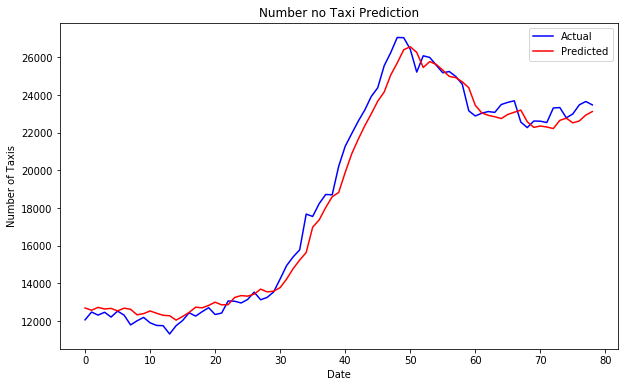

In [142]:
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(10,6))  
plt.plot(test[0:79], color='blue', label='Actual')  
plt.plot(predictions[0:79] , color='red', label='Predicted')  
plt.title('Number no Taxi Prediction')  
plt.xlabel('Date')  
plt.ylabel('Number of Taxis')  
plt.legend()  
plt.show()  

In [143]:
np.mean(np.abs((predictions[0:test.shape[0]-1]-test[0:test.shape[0]-1])/test[0:test.shape[0]-1]))

0.029297142196982935

In [144]:
from sklearn.metrics import r2_score
r2_score(test[0:79],predictions[0:79])

0.9853608608247174

In [145]:
over = model.predict(features_set)
over = scaler.inverse_transform(over)

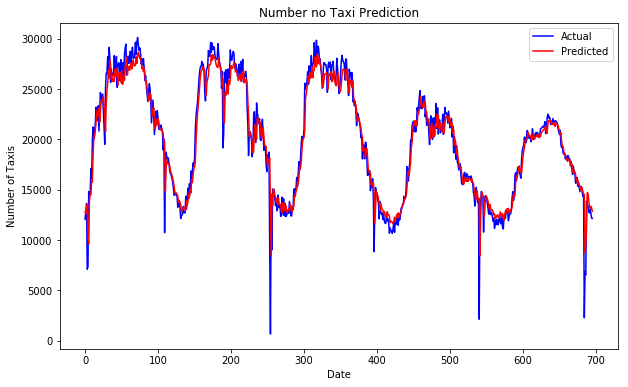

In [146]:
train_ = scaler.inverse_transform(labels.reshape(-1,1))


plt.figure(figsize=(10,6))  
plt.plot(train[80:], color='blue', label='Actual')  
plt.plot(over , color='red', label='Predicted')  
plt.title('Number no Taxi Prediction')  
plt.xlabel('Date')  
plt.ylabel('Number of Taxis')  
plt.legend()  
plt.show()  


In [147]:
np.mean(np.abs((train[80:]-over)/train[80:]))

0.09497390598942239

In [148]:
r2_score(train[80:],over)

0.9234865218729751

# LSTM 2 with more features

In [36]:
prova_copy.columns

Index(['taxi_count', 'working_or_not', 'is_sun_up', 'time_to_eat',
       'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'Weekday_Wednesday'],
      dtype='object')

In [31]:
prova_copy.drop(prova_copy.columns[1:33],axis=1,inplace=True)

In [38]:
prova_copy.head()

,taxi_count,working_or_not,is_sun_up,time_to_eat,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,25228,0,1,0,0,0,1,0,0,0,0
1,26383,0,0,0,0,0,1,0,0,0,0
2,24781,0,0,0,0,0,1,0,0,0,0
3,25488,0,0,1,0,0,1,0,0,0,0
4,24913,0,0,1,0,0,1,0,0,0,0


In [40]:
X2 = prova_copy[prova_copy.columns[1:]].values
Y2 = prova_copy["taxi_count"].values

In [45]:
x_train, x_test, y_train, y_test = X2[1:-81], X2[-81:861], Y2[1:-81], Y2[-81:861]

In [50]:
scaler = MinMaxScaler(feature_range=(0,1))
#They work better in this range (0,1)
#We fit according to the traning set, since we
#assume not to have access to the test set
y_train_scaled = scaler.fit_transform(y_train.reshape(-1,1)) 

In [281]:
x_train.shape

(780, 42)

In [56]:
#number of records to use to predict the future.
old_record_number=80
features_set = []  
labels = []  
#Use N=old_record_number to predict to next one
#we create the N features for the Neurons inputs and
# the label contain the y values
#so basically a x_train and a y_train
for i in range(old_record_number, len(x_train)):  
    features_set.append(x_train[i-old_record_number:i, :])
    labels.append(y_train_scaled[i])
    
# We need them as np array
features_set, labels = np.array(features_set), np.array(labels)  

#Reshape them according to what LSTM wants:
# - A three dimensional array where the:
#   - first dim is the number of records
#   - second dim is the number of steps (old_record_number)
#   - third dim is the number of variabiles (for us 1, since we use only the taxi_count)
features_set = np.reshape(features_set, 
                          (features_set.shape[0], 
                           features_set.shape[1], 
                           10))  #Using 10 feature

In [58]:
features_set.shape

(700, 80, 10)

In [91]:
%%time
model = LSTM_NN(units=[128,128,64],drop=[0.2,0.1,0.1],epochs=100,
                    batch_size=20,x_train=features_set,y_train=labels).get_model()

Epoch 1/100
700/700 [==============================] - 15s 22ms/sample - loss: 0.1937 - mean_squared_error: 0.0859
Epoch 2/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.1107 - mean_squared_error: 0.0200
Epoch 3/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.1000 - mean_squared_error: 0.0157
Epoch 4/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.0902 - mean_squared_error: 0.0128
Epoch 5/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.0842 - mean_squared_error: 0.0115
Epoch 6/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.0756 - mean_squared_error: 0.0095
Epoch 7/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.0748 - mean_squared_error: 0.0095
Epoch 8/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.0729 - mean_squared_error: 0.0093
Epoch 9/100
700/700 [==============================] - 13s 18ms/sample - loss: 0

700/700 [==============================] - 13s 18ms/sample - loss: 0.0394 - mean_squared_error: 0.0035
Epoch 72/100
700/700 [==============================] - 13s 19ms/sample - loss: 0.0396 - mean_squared_error: 0.0036
Epoch 73/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.0406 - mean_squared_error: 0.0038
Epoch 74/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.0391 - mean_squared_error: 0.0036
Epoch 75/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.0390 - mean_squared_error: 0.0036
Epoch 76/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.0404 - mean_squared_error: 0.0037
Epoch 77/100
700/700 [==============================] - 12s 18ms/sample - loss: 0.0390 - mean_squared_error: 0.0035
Epoch 78/100
700/700 [==============================] - 12s 18ms/sample - loss: 0.0393 - mean_squared_error: 0.0035
Epoch 79/100
700/700 [==============================] - 13s 18ms/sample - loss: 0.040

In [92]:
test_inputs = X2[len(X2)-len(x_test)-old_record_number:]

In [93]:
test_inputs.shape

(160, 10)

In [94]:
test_features = []  
for i in range(old_record_number, len(test_inputs)):  
    test_features.append(test_inputs[i-old_record_number:i, :])

test_features = np.array(test_features)
test_features = np.reshape(test_features, 
                           (test_features.shape[0], 
                            test_features.shape[1], 
                            10)) 

In [95]:
test_features.shape

(80, 80, 10)

In [96]:
predictions = model.predict(test_features)


In [97]:
predictions = scaler.inverse_transform(predictions)

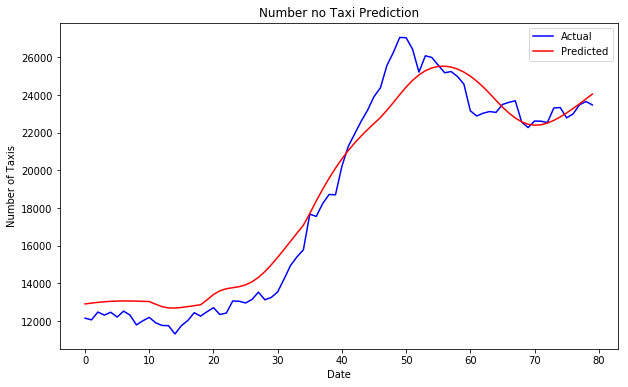

In [98]:
plt.figure(figsize=(10,6))  
plt.plot(y_test, color='blue', label='Actual')  
plt.plot(predictions , color='red', label='Predicted')  
plt.title('Number no Taxi Prediction')  
plt.xlabel('Date')  
plt.ylabel('Number of Taxis')  
plt.legend()  
plt.show()  

In [99]:
np.mean(np.abs((predictions-y_test.reshape(-1,1))/y_test.reshape(-1,1)))

0.052866362135329734

In [100]:
r2_score(y_test,predictions)

0.961453443126755

Using all the features it is too slow, and less precise but somehow is able to approximate the data with a smooth function!?

In [101]:
over = model.predict(features_set)
over = scaler.inverse_transform(over)

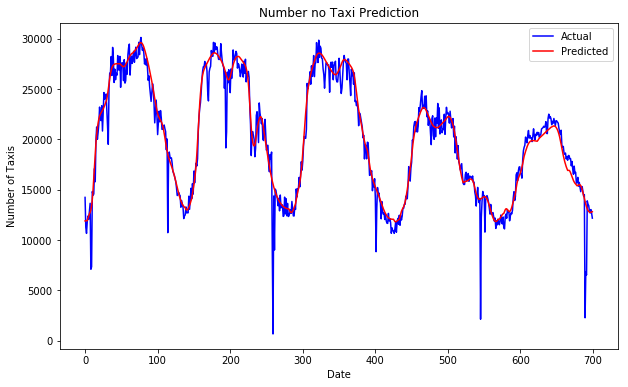

In [104]:
plt.figure(figsize=(10,6))  
plt.plot(y_train[80:], color='blue', label='Actual')  
plt.plot(over , color='red', label='Predicted')  
plt.title('Number no Taxi Prediction')  
plt.xlabel('Date')  
plt.ylabel('Number of Taxis')  
plt.legend()  
plt.show()  

In [87]:
np.mean(np.abs((over-y_train[80:].reshape(-1,1))/y_train[80:].reshape(-1,1)))

0.11939615040891913

In [90]:
r2_score(y_train[80:],over)

0.8953137477529537